<img src="https://crowdmark-com.s3.amazonaws.com/website/images/visual-identity/crowdmark-logo-dark.png" alt="PIMS logo" width ="180" align="right">

# Exploring the Crowdmark API

[Crowdmark API Guide (draft version)](https://gist.github.com/heycarsten/46060b3cfce1eaeed325ddd3cdb79f0b)

[Draft Documentation Site](http://scattered-island.surge.sh/)

Goals: Use the Crowdmark API to
1. List all the assessments by their `id` in a given course
1. Extract student associated with a given booklet
2. Extract assessment_id from slug

In [11]:
## Some math and data tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import simplejson as json

In [2]:
# Import seaborn for visualizing data graphically
import seaborn as sns
sns.set()

In [3]:
## For graphing in this notebook
%matplotlib inline

## Enter your Crowdmark API key

In [4]:
## Execute this cell to generate a request for your API key.
## Paste your api key into the text field (and press enter); Comment out the next line to define your API Key.
# api = input("What is your Crowdmark API key:")

In [5]:
## This cell writes the content of `api` to the file .crowdmark-key.

#with open(".crowdmark-key", "w") as text_file:
#   print(f"{api}", file=text_file)

In [6]:
# This cell reads in the .crowdmark-key file and saves it as apiKey.
# The API key allows the computer hosting your Jupyter notebook to programmatically access data from Crowdmark.
with open(".crowdmark-key", 'r') as f:
    apiKey = f.read().rstrip()
# apiKey

In [7]:
## Define the URL endpoint for accessing the booklets data from the Crowdmark API.
cm = 'https://app.crowdmark.com'

## Specify the Course

In [8]:
## SPECIFY THE COURSE YOU WISH TO INVESTIGATE HERE
# course_slug = 'demos'

course_slug ='samples'

In [9]:
## Define the URL endpoint for accessing the API data.
cm = 'https://app.crowdmark.com'

# api_endpoint = '/api/users/{user-id}'
# api_endpoint = '/api/courses/'
# api_endpoint = '/api/courses/2015mat127-7934f/assessments'
# api_endpoint = '/api/assessments'
# api_endpoint = '/api/assessments/mat217-assignment-4/enrollments'
# api_endpoint = '/api/assessments/mat217-assignment-4/memberships'
# api_endpoint = '/api/assessments/mat217-assignment-4/questions'
# booklets_endpoint = '/api/assessments/' + assessment_slug +'/booklets'
assessments_endpoint = '/api/courses/' + course_slug + '/assessments'
# enrollments_endpoint = '/api/assessments/' + assessment_slug + '/enrollments'
# bookletsURL = cm + booklets_endpoint + '?api_key=' + apiKey
assessmentsURL = cm + assessments_endpoint + '?api_key=' + apiKey
# enrollmentsURL = cm + enrollments_endpoint + '?api_key=' + apiKey


In [12]:
from urllib.request import urlopen

# booklets_response = urlopen(bookletsURL).read().decode('utf8')
# booklets = json.loads(booklets_response)

assessments_response = urlopen(assessmentsURL).read().decode('utf8')
assessments = json.loads(assessments_response)

# enrollments_response = urlopen(enrollmentsURL).read().decode('utf8')
# enrollments = json.loads(enrollments_response)

## Our data set has been pulled from bookletsURL and is now encoded as python dictionary in `booklets`.

## List Assessments in a Course

In [13]:
assessments

{'links': {'self': '/api/courses/samples/assessments',
  'first': '/api/courses/samples/assessments',
  'last': '/api/courses/samples/assessments?page%5Bnumber%5D=1'},
 'meta': {'total': 13, 'page-size': 50, 'max-page-size': 100},
 'data': [{'type': 'assessment',
   'id': 'testing-assessment-creation-after-courses',
   'links': {'self': '/api/assessments/testing-assessment-creation-after-courses'},
   'attributes': {'title': 'testing assessment creation after courses',
    'type': 'assigned',
    'due-at': '2016-05-10T07:00:59.000Z',
    'penalty-period': 'day',
    'penalty-value': 15,
    'created-at': '2016-05-10T06:45:40.035Z',
    'updated-at': '2021-02-18T03:01:10.400Z'},
   'relationships': {'course': {'data': {'type': 'course', 'id': 'samples'},
     'links': {'self': '/api/courses/samples'}},
    'booklets': {'links': {'related': '/api/assessments/testing-assessment-creation-after-courses/booklets'},
     'meta': {'count': 1}},
    'enrollments': {'links': {'related': '/api/as

In [14]:
## List all the assessments in a course
for k in range(0,len(assessments['data'])):
    print(assessments['data'][k]['id'])

testing-assessment-creation-after-courses
math-sample-assessment-3147c
math-sample-assessment-dc111
math-sample-assessment-5682b
math-sample-assessment-9045b
math-sample-assessment-extra
math-sample-assessment-cd5f7
math-sample-assessment-fe8c2
math-sample-assessment-29417
west-caldwell-exam
calculus-1b-midterm-1
math-sample-assessment
math-121-fall-2016-midterm-1


## Loop to merge all assessments

In [15]:
## List all the assessments in a course
for k in range(0,len(assessments['data'])):
    print(assessments['data'][k]['id'])

testing-assessment-creation-after-courses
math-sample-assessment-3147c
math-sample-assessment-dc111
math-sample-assessment-5682b
math-sample-assessment-9045b
math-sample-assessment-extra
math-sample-assessment-cd5f7
math-sample-assessment-fe8c2
math-sample-assessment-29417
west-caldwell-exam
calculus-1b-midterm-1
math-sample-assessment
math-121-fall-2016-midterm-1


In [16]:
## Configure the first data frame
url0 = 'https://app.crowdmark.com/api/assessments/' + assessments['data'][0]['id'] + '/results.csv' + '?api_key=' + apiKey
dgd = pd.read_csv(url0)
## Ingore some columns
dgd = dgd.drop(['Crowdmark ID', 'Score URL', 
                 'Total', 'Penalty', 'Total After Penalty','Submitted At', 
                'Username', 'First Name', 'Last Name', 
                'Canvas ID', 'Email.1', 'Name', 'Student ID', 
                'first_name', 'full_name', 'id', 'last_name'], axis=1, errors='ignore')

In [17]:
dgd.head(n=12)

,Email,Q1,Q2,Q3,Q4,Q5,Q6,MC-total,Started At,Custom Penalty,State
0,colliand+student1@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,Not viewed


In [18]:
dgd.columns

Index(['Email', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'MC-total', 'Started At',
       'Custom Penalty', 'State'],
      dtype='object')

In [19]:
## Merge scores from all the assessments in the course into a single data frame.
for k in range(1,len(assessments['data'])):
## for k in range(1,2):
    print(assessments['data'][k]['id'])
    assess_slug = assessments['data'][k]['id']
    #URL for API, Crowdmark API URL in this case
    url1 = 'https://app.crowdmark.com/api/assessments/' + assess_slug + '/results.csv' + '?api_key=' + apiKey
    dg1 = pd.read_csv(url1)
    dg1 = dg1.drop(['Crowdmark ID', 'Score URL', 
                 'Total', 'Penalty', 'Total After Penalty','Submitted At', 
                'Username', 'First Name', 'Last Name', 
                'Canvas ID', 'Email.1', 'Name', 'Student ID', 
                'first_name', 'full_name', 'id', 'last_name'], axis=1, errors='ignore')
    dgd = dgd.merge(dg1, left_on=['Email'], 
                 right_on=['Email'], how='outer')

math-sample-assessment-3147c
math-sample-assessment-dc111
math-sample-assessment-5682b


/home/colliand/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Q1_x', 'Q2_x', 'MC-total_x', 'Q3_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


math-sample-assessment-9045b


/home/colliand/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Section_x', 'Student ID Number_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


math-sample-assessment-extra
math-sample-assessment-cd5f7
math-sample-assessment-fe8c2
math-sample-assessment-29417
west-caldwell-exam
calculus-1b-midterm-1
math-sample-assessment


/home/colliand/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Section_x', 'Q1_x', 'Student ID Number_x', 'MC-total_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


math-121-fall-2016-midterm-1


/home/colliand/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Q2_x', 'Q3_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [20]:
dgd.columns.max

<bound method IndexOpsMixin.max of Index(['Email', 'Q1_x', 'Q2_x', 'Q3_x', 'Q4_x', 'Q5_x', 'Q6_x', 'MC-total_x',
       'Started At', 'Custom Penalty', 'State', 'Student ID Number_x',
       'Section_x', 'Q1_y', 'Q2_y', 'Q3_y', 'MC-total_y',
       'Student ID Number_y', 'Section_y', 'Q1_x', 'Q2_x', 'Q3_x',
       'MC-total_x', 'Student ID Number_x', 'Section_x', 'Q1_y', 'Q2_y',
       'Q3_y', 'MC-total_y', 'Student ID Number_y', 'Section_y', 'Q1_x',
       'Q2_x', 'Q3_x', 'MC-total_x', 'Student ID Number_x', 'Section_x',
       'Q1_y', 'Q2_y', 'Q3_y', 'MC-total_y', 'Student ID Number_y',
       'Section_y', 'Q1_x', 'Q2_x', 'Q3_x', 'MC-total_x',
       'Student ID Number_x', 'Section_x', 'Q1_y', 'Q2_y', 'Q3_y',
       'MC-total_y', 'Student ID Number_y', 'Section_y', 'Q1_x', 'Q2_x',
       'Q3_x', 'MC-total_x', 'Q1_y', 'Q2_y', 'Q3_y', 'MC-total_y',
       'Student ID Number_x', 'Section_x', 'Q1_x', 'MC-total_x',
       'Student ID Number_y', 'Section_y', 'Q1_y', 'Q2_x', 'Q3_x',
       

## Analyze the Scores in the Class

In [21]:
## Cut and Paste the Question Score Columns
dgda = dgd[['Q1_x', 'Q2_x', 'Q3_x', 'Q4_x', 'Q5_x', 'Q6_x', 'Q1_y', 'Q2_y',
       'Q3_y', 'Q4_y', 'Q5_y', 'Q6_y', 'Q7', 'Q1_x', 'Q2_x', 'Q3_x', 'Q1_x',
       'Q2_y', 'Q3_y', 'Q1_y', 'Q2_x', 'Q3_x', 'Q1_x', 'Q2_y', 'Q3_y', 'Q1_y',
       'Q2_x', 'Q3_x', 'Q1_x', 'Q2_y', 'Q3_y','Q1_y', 'Q2_x', 'Q3_x', 'Q1_x',
       'Q2_y', 'Q3_y', 'Q1_y', 'Q2_x', 'Q3_x','Q1', 'Q2_y', 'Q3_y']]

In [22]:
dgda

,Q1_x,Q1_x,Q1_x,Q1_x,Q1_x,Q1_x,Q2_x,Q2_x,Q2_x,Q2_x,...,Q2_y,Q2_y,Q2_y,Q2_y,Q3_y,Q3_y,Q3_y,Q3_y,Q3_y,Q3_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,6.0,NaN,NaN,6.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,NaN,6.0,NaN,NaN,6.0,3.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,NaN,10.0,NaN,NaN,10.0,NaN,NaN,10.0,NaN,NaN,...,NaN,5.9,NaN,NaN,10.0,NaN,NaN,6.0,NaN,NaN
4,NaN,0.0,NaN,NaN,0.0,10.0,NaN,0.0,NaN,NaN,...,NaN,2.0,NaN,NaN,0.0,NaN,NaN,3.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,9.0
412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,9.0
413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,8.5
414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [23]:
corr = dgda.corr

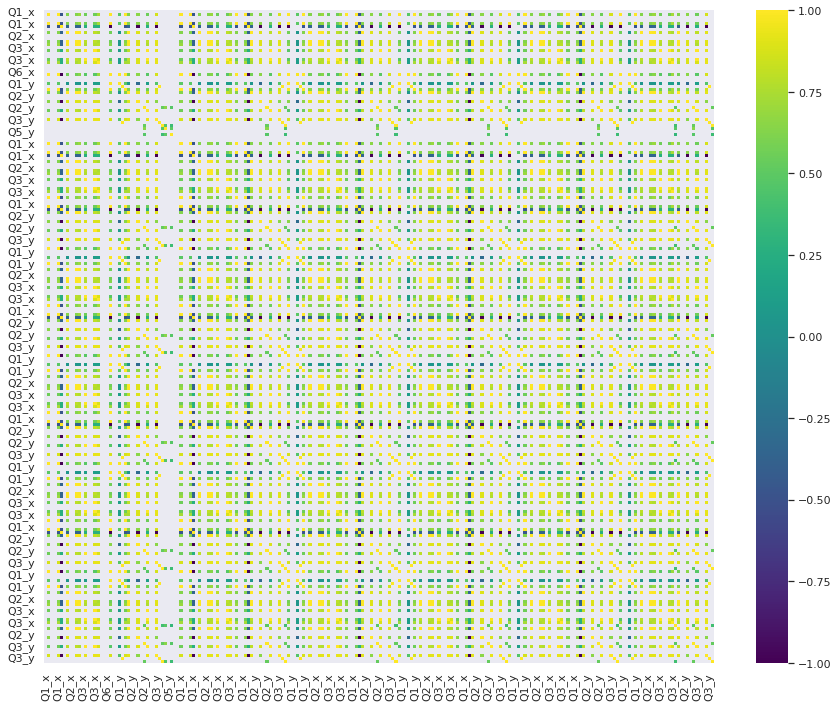

In [24]:
plt.figure(figsize = (15,12))
ax = sns.heatmap(corr('pearson'), cmap="viridis")

In [25]:
len(dgda)

416